<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/opt_plus_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import itertools


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import itertools

def run_experiment(X):
    """
    Simulates the reaction rate based on concentration (c) and temperature (T)
    with multiple local maxima and randomness.

    Args:
        c: Reactant concentration (mM).
        T: Temperature (°C).

    Returns:
        Simulated reaction rate (mole/s).
    """
    # Introduce multiple maxima using a combination of functions
    # We'll use a base rate with some peaks
    base_rate = 3.0  # Adjusted base rate
    c=X[0]
    T=X[1]
    # Adding some peaks - shifting centers and adjusting magnitudes
    peak1 = 8 * np.exp(-((c - 1.5)**2 / 0.5 + (T - 20)**2 / 50)) # Shifted and adjusted magnitude
    peak2 = 6 * np.exp(-((c - 0.5)**2 / 0.8 + (T - 10)**2 / 80)) # Shifted and adjusted magnitude
    peak3 = 10 * np.exp(-((c - 2.5)**2 / 0.6 + (T - 35)**2 / 60)) # Shifted and adjusted magnitude
    peak4 = 7 * np.exp(-((c - 3.0)**2 / 0.7 + (T - 45)**2 / 70)) # Shifted and adjusted magnitude


    # Combine the base rate and peaks
    simulated_rate = base_rate + peak1 + peak2 + peak3 + peak4

    # Add some randomness to the experimental data
    randomness = np.random.normal(0, 0.05)  # Adjust standard deviation for desired randomness

    return np.maximum(0, simulated_rate + randomness) # Ensure rate is not negative

# Example usage:
X=[2.0, 25.0]
rate_example = run_experiment(X)
print(f"Reaction rate at c={X[0]} mM and T={X[1]} °C: {rate_example:.2f} mole/s")

Reaction rate at c=2.0 mM and T=25.0 °C: 7.25 mole/s


reaction rate at c=2.0 mM and T=25C:  7.22555067476464


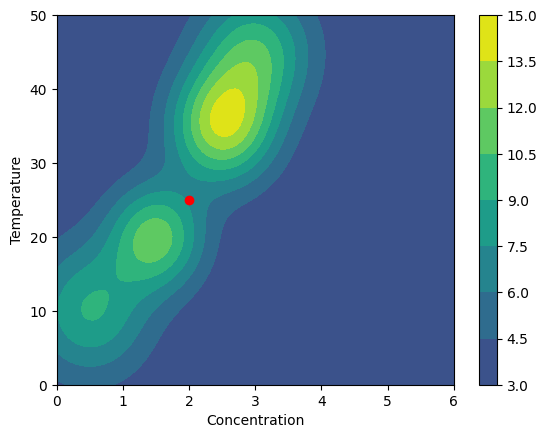

In [3]:
y_t = np.round(np.linspace(0,50,101),2)
x_t = np.round(np.linspace(0,6,101),2)
X, Y = np.meshgrid(x_t,y_t)
Z = run_experiment([X,Y])
plt.contourf(x_t,y_t,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(2, 25, color='r')
plt.xlabel('Concentration')
plt.ylabel('Temperature')
print('reaction rate at c=2.0 mM and T=25C: ',run_experiment([2,25]))

In [4]:
def encode(inputs_df):
    inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
    inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)
    inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
    inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)
    inputs_df = inputs_df.drop(['average','span'],axis=1)
    return inputs_df


def iterate(inputs_df, repeat=1):
    le=len(inputs_df.index.tolist())
    if le==2:
        encoded_inputs= list(itertools.product([inputs_df.encoded_low.x, inputs_df.encoded_high.x],[inputs_df.encoded_low.y,inputs_df.encoded_high.y]))
    if set(['center']).issubset(inputs_df.columns):
        for i in range(0,repeat):
            encoded_inputs.append((0,0))
            encoded_inputs
    return encoded_inputs

def real_experiment(encoded_df, inputs_df):
    real_exp = encoded_df
    var_labels = []
    for var in inputs_df.index.tolist():
        var_label = inputs_df.loc[var]['label']
        var_labels.append(var_label)
        if set(['center']).issubset(inputs_df.columns):
            real_exp[var_label] = encoded_df.apply(lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']),axis=1)
        else:
            real_exp[var_label] = encoded_df.apply(lambda z : inputs_df.loc[var]['low'] if z[var]<0 else inputs_df.loc[var]['high'], axis=1)

    return real_exp[var_labels]


In [5]:
inputs_labels = {'x' : 'Concentration',
                 'y' : 'Temperature'}


# DOE1
ymin=23
ymax=27
xmin=1.8
xmax=2.2

dat = [('x',xmin, 2.0, xmax),
       ('y',ymin,25.0,ymax)]

inputs_doe1_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_doe1_df = inputs_doe1_df.set_index(['index'])
inputs_doe1_df['label'] = inputs_doe1_df.index.map( lambda z : inputs_labels[z] )

inputs_doe1_df

,low,center,high,label
index,,,,
x,1.8,2.0,2.2,Concentration
y,23.0,25.0,27.0,Temperature


In [6]:
inputs_doe1_df=encode(inputs_doe1_df)
encoded_inputs=iterate(inputs_doe1_df, repeat=1)
encoded_df=pd.DataFrame(encoded_inputs, columns=inputs_doe1_df.index.tolist())

In [7]:
real_doe1_df=real_experiment(encoded_df, inputs_doe1_df)
print("The values of each real variable in the experiment:")
real_doe1_df

The values of each real variable in the experiment:


,Concentration,Temperature
0,1.8,23.0
1,1.8,27.0
2,2.2,23.0
3,2.2,27.0
4,2.0,25.0


In [8]:
resp=[]
results_doe1=encoded_df
for i in range(len(real_doe1_df)):
  resp.append(run_experiment([real_doe1_df['Concentration'][i],real_doe1_df['Temperature'][i]]))

results_doe1['Response']=resp
results_doe1

,x,y,Concentration,Temperature,Response
0,-1.0,-1.0,1.8,23.0,9.035110
1,-1.0,1.0,1.8,27.0,7.090809
2,1.0,-1.0,2.2,23.0,6.321176
3,1.0,1.0,2.2,27.0,7.094096
4,0.0,0.0,2.0,25.0,7.230748


Text(0, 0.5, 'Temperature')

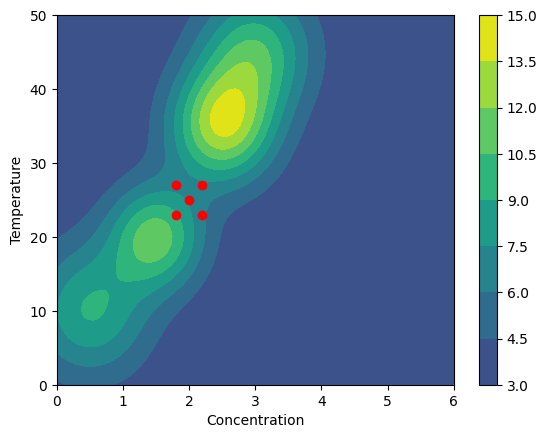

In [9]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe1.Concentration, results_doe1.Temperature,c='r')
plt.xlabel('Concentration')
plt.ylabel('Temperature')

We see from the result that we are sitting in a "valley". Here we should choose either [-1-1] or [1,1] and investigate which direction to take.

In [10]:
results_doe1

,x,y,Concentration,Temperature,Response
0,-1.0,-1.0,1.8,23.0,9.035110
1,-1.0,1.0,1.8,27.0,7.090809
2,1.0,-1.0,2.2,23.0,6.321176
3,1.0,1.0,2.2,27.0,7.094096
4,0.0,0.0,2.0,25.0,7.230748


In [11]:
#step in [1,1] direction gives:
new_row_1 = pd.DataFrame({
    'x': [results_doe1['x'][3] + (0.2/0.2)], # Assuming the step is in encoded space, 0.1 change in real is 0.1/span = 0.1/0.2 = 0.5 in encoded
    'y': [results_doe1['y'][3] + (2/2.0)], # Assuming the step is in encoded space, 1 change in real is 1/span = 1/2.0 = 0.5 in encoded
    'Concentration': [real_doe1_df['Concentration'][3] + 0.2],
    'Temperature': [real_doe1_df['Temperature'][3] + 2],
    'Response': [run_experiment([real_doe1_df['Concentration'][3] + 0.1,real_doe1_df['Temperature'][3] + 1])]
})

results_doe1 = pd.concat([results_doe1, new_row_1], ignore_index=True)

#step in [-1,-1] direction gives:
new_row_2 = pd.DataFrame({
    'x': [results_doe1['x'][0] - (0.2/0.2)], # Assuming the step is in encoded space
    'y': [results_doe1['y'][0] - (2/2.0)], # Assuming the step is in encoded space
    'Concentration': [real_doe1_df['Concentration'][0] - 0.2],
    'Temperature': [real_doe1_df['Temperature'][0] - 2],
    'Response': [run_experiment([real_doe1_df['Concentration'][0] - 0.2,real_doe1_df['Temperature'][0] - 2])]
})
results_doe1 = pd.concat([results_doe1, new_row_2], ignore_index=True)


# To add to the numpy arrays x_t and y_t for plotting, use np.append
#x_t = np.append(x_t, [real_doe1_df['Concentration'][3] + 0.1, real_doe1_df['Concentration'][0] - 0.1])
#y_t = np.append(y_t, [real_doe1_df['Temperature'][3] + 1, real_doe1_df['Temperature'][0] - 1])

print(results_doe1)

     x    y  Concentration  Temperature   Response
0 -1.0 -1.0            1.8         23.0   9.035110
1 -1.0  1.0            1.8         27.0   7.090809
2  1.0 -1.0            2.2         23.0   6.321176
3  1.0  1.0            2.2         27.0   7.094096
4  0.0  0.0            2.0         25.0   7.230748
5  2.0  2.0            2.4         29.0   7.705847
6 -2.0 -2.0            1.6         21.0  11.034620


Text(0, 0.5, 'Temperature')

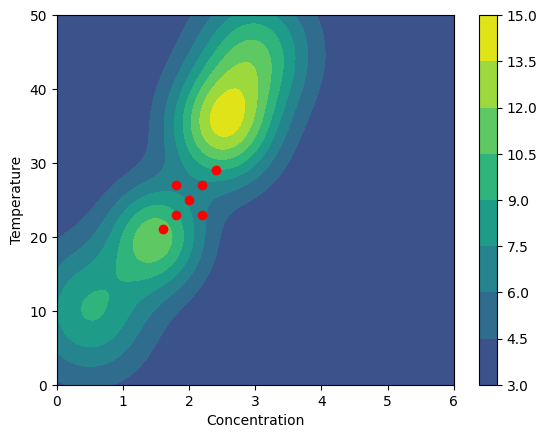

In [12]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe1.Concentration, results_doe1.Temperature,c='r')
plt.xlabel('Concentration')
plt.ylabel('Temperature')

In [13]:
inputs_labels = {'x' : 'Temperature',
                 'y' : 'Concentration'}

xmin=19
xmax=21
ymin=1.4
ymax=1.6

dat = [('x',xmin,(xmin+xmax)/2,xmax),
       ('y',ymin,(ymin+ymax)/2,ymax)]

inputs_doe2_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_doe2_df = inputs_doe2_df.set_index(['index'])
inputs_doe2_df['label'] = inputs_doe2_df.index.map( lambda z : inputs_labels[z] )

inputs_doe2_df

,low,center,high,label
index,,,,
x,19.0,20.0,21.0,Temperature
y,1.4,1.5,1.6,Concentration


In [14]:

inputs_doe2_df=encode(inputs_doe2_df)
encoded_inputs=iterate(inputs_doe2_df)
encoded_df=pd.DataFrame(encoded_inputs, columns=inputs_doe2_df.index.tolist())

In [15]:
real_doe2_df=real_experiment(encoded_df, inputs_doe2_df)
print("The values of each real variable in the experiment:")
real_doe2_df

The values of each real variable in the experiment:


,Temperature,Concentration
0,19.0,1.4
1,19.0,1.6
2,21.0,1.4
3,21.0,1.6
4,20.0,1.5


In [16]:
resp=[]
results_doe2=encoded_df
for i in range(len(real_doe2_df)):
  resp.append(run_experiment([real_doe2_df['Concentration'][i],real_doe2_df['Temperature'][i]]))

results_doe2['Response']=resp
results_doe2

,x,y,Temperature,Concentration,Response
0,-1.0,-1.0,19.0,1.4,11.510145
1,-1.0,1.0,19.0,1.6,11.237398
2,1.0,-1.0,21.0,1.4,11.321928
3,1.0,1.0,21.0,1.6,11.046568
4,0.0,0.0,20.0,1.5,11.504015


Maximum is in center, seems like we have a nonlinear function.

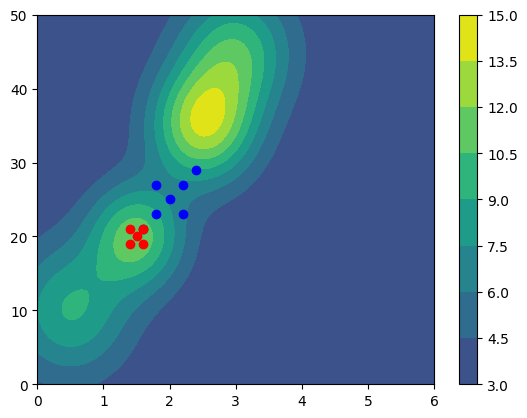

In [17]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe1.Concentration,results_doe1.Temperature, c='b')
plt.scatter(results_doe2.Concentration,results_doe2.Temperature, c='r')

In [18]:
!pip install doepy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for diversipy: filename=diversipy-0.9-py3-none-any.whl size=27698 sha256=bc82d69f0ba99768e26a53ba25b6720ca30febe596dbbc03b60a405a0b6f2f53
  Stored in directory: /root/.cache/pip/wheels/0c/82/74/0402038c9a5549102f03f2b84b6c86c9d5dce26657cf4d5d1c
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=43835aa0a457e30da8c42b5eadbddc9fd5d0f389b6276c0423e145e7fd4648bb
  Stored in directory: /root/.cache/pip/wheels/96/b9/5d/1138ea8c8f212bce6e97ae58847b7cc323145b3277f2129e2b
Successfully built diversipy pyDOE


In [19]:
from doepy import read_write, build
lhs=build.space_filling_lhs(
{'x':[1.3, 1.7],
'y':[18, 22]},
num_samples = 12
)

In [20]:
resp=[]
results_lhs=lhs
for i in range(len(lhs)):
  resp.append(run_experiment([lhs['x'][i],lhs['y'][i]]))

results_lhs['Response']=resp
results_lhs

,x,y,Response
0,1.700000,18.727273,10.519439
1,1.445455,21.272727,11.144326
2,1.300000,18.000000,11.060396
3,1.481818,19.090909,11.615230
4,1.372727,19.454545,11.531598
5,1.336364,19.818182,11.286769
6,1.627273,20.909091,11.044455
7,1.409091,18.363636,11.423876
8,1.554545,20.545455,11.371407
9,1.590909,22.000000,10.586668


In [21]:
# Standardize the 'x' and 'y' variables
results_lhs['x_standardized'] = (results_lhs['x'] - results_lhs['x'].mean()) / results_lhs['x'].std()
results_lhs['y_standardized'] = (results_lhs['y'] - results_lhs['y'].mean()) / results_lhs['y'].std()


res2 = smf.ols(formula='Response ~ x_standardized + y_standardized + x_standardized:y_standardized + I(x_standardized**2) + I(y_standardized**2)', data=results_lhs).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     398.7
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           1.77e-07
Time:                        20:35:32   Log-Likelihood:                 29.366
No. Observations:                  12   AIC:                            -46.73
Df Residuals:                       6   BIC:                            -43.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

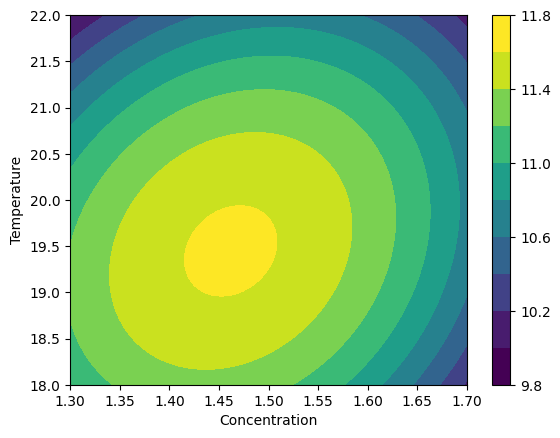

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

x_m = np.linspace(results_lhs['x'].min(), results_lhs['x'].max(), 100)
y_m = np.linspace(results_lhs['y'].min(), results_lhs['y'].max(), 100)
X, Y = np.meshgrid(x_m, y_m)

# Create a DataFrame for prediction with standardized variables
data_pred = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
data_pred['x_standardized'] = (data_pred['x'] - results_lhs['x'].mean()) / results_lhs['x'].std()
data_pred['y_standardized'] = (data_pred['y'] - results_lhs['y'].mean()) / results_lhs['y'].std()


c = res2.predict(data_pred)
Z_pred = c.values.reshape(X.shape)

data=data_pred
data['y_pred']=c
plt.contourf(x_m, y_m, Z_pred, levels=10, vmin=c.min(), vmax=c.max())
plt.colorbar()

plt.xlabel('Concentration')
plt.ylabel('Temperature')
plt.show()

In [34]:
data['y_pred'].idxmax()
d=data.iloc[data['y_pred'].idxmax()]
d

,3640
x,1.461616
y,19.454545
x_standardized,-0.292758
y_standardized,-0.416025
y_pred,11.634104


In [36]:
run_experiment([d['x'], d['y']])


np.float64(11.616952624732072)

I'll guess we are happy with this result. We have found the closest minima.

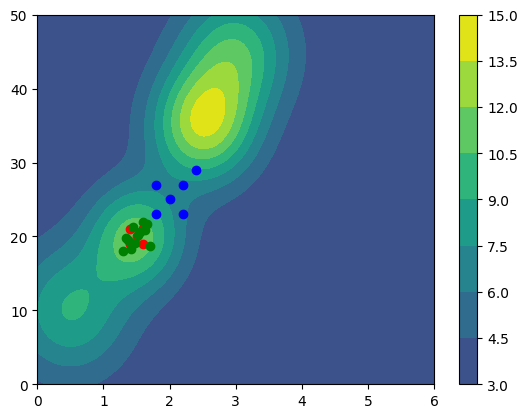

In [37]:
plt.contourf(x_t, y_t, Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(results_doe1.Concentration,results_doe1.Temperature, c='b')
plt.scatter(results_doe2.Concentration,results_doe2.Temperature, c='r')
plt.scatter(results_lhs.x,results_lhs.y, c='g')


But we missed the larger maximum!  

Let's test another method that can perhaps solve this.


# Bayesian optimisation
Find the maximum of the `run_experiment` function using Bayesian Optimization.

In [40]:
!pip install bayesian-optimization


## Define the search space
Specify the range of values for Concentration and Temperature where the optimization will occur.


In [83]:
pbounds = {'Concentration': (1, 4), 'Temperature': (15, 40)}

## Set up bayesian optimization

### Subtask:
Initialize the `BayesianOptimization` object with the `run_experiment` function and the defined search space.


**Reasoning**:
Initialize the BayesianOptimization object with the target function and the parameter bounds.



In [84]:
from bayes_opt import BayesianOptimization
from bayes_opt.acquisition import ExpectedImprovement
optimizer = BayesianOptimization(
    f=run_experiment,
    acquisition_function=ExpectedImprovement,
    pbounds=pbounds,
    random_state=1,
)

## Perform optimization

Run the optimization process to find the input parameters that maximize the reaction rate.


In [85]:
def run_experiment_wrapper(Concentration, Temperature):
  """Wrapper function to adapt run_experiment for Bayesian Optimization."""
  return run_experiment([Concentration, Temperature])

optimizer = BayesianOptimization(
    f=run_experiment_wrapper,
    pbounds=pbounds,
    random_state=10,
)

optimizer.maximize(
    init_points=5,
    n_iter=15
)

|   iter    |  target   | Concen... | Temper... |
-------------------------------------------------
| 1         | 3.0181780 | 3.3139619 | 15.518798 |
| 2         | 11.634452 | 2.9009447 | 33.720097 |
| 3         | 4.3987541 | 2.4955210 | 20.619916 |
| 4         | 5.7225152 | 1.5941885 | 34.013267 |
| 5         | 10.732206 | 1.5073325 | 17.208495 |
| 6         | 3.4548453 | 2.8375782 | 20.048746 |
| 7         | 4.4555328 | 3.6930872 | 33.542381 |
| 8         | 12.062636 | 2.8486786 | 33.721760 |
| 9         | 13.210170 | 2.5055570 | 33.206889 |
| 10        | 11.326116 | 2.2433338 | 32.251845 |
| 11        | 9.3655351 | 2.8901754 | 31.128046 |
| 12        | 4.0879936 | 1.2578414 | 31.418922 |
| 13        | 9.3375694 | 3.0256017 | 32.352688 |
| 14        | 9.4888727 | 1.0       | 18.176259 |
| 15        | 9.3762763 | 1.0       | 16.223255 |
| 16        | 4.4224783 | 2.4236236 | 17.816681 |
| 17        | 8.4500916 | 1.8984179 | 32.902019 |
| 18        | 13.479931 | 2.7135907 | 34.612032 |


## Visualize the results
Plot the points explored by the Bayesian Optimization algorithm on the contour plot of the `run_experiment` function to see where the optimization focused.


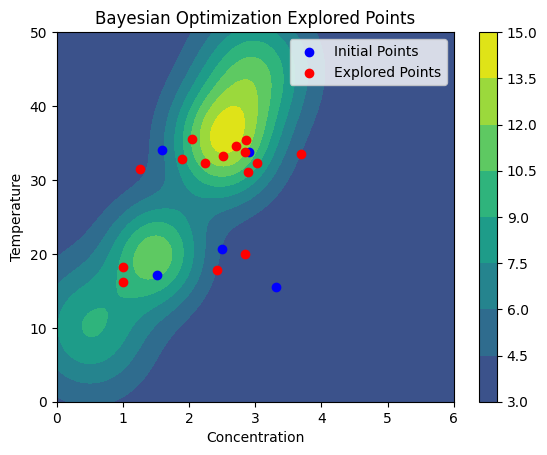

In [86]:
# Generate contour plot of the run_experiment function
y_t = np.round(np.linspace(0, 50, 101), 2)
x_t = np.round(np.linspace(0, 6, 101), 2)
X, Y = np.meshgrid(x_t, y_t)
Z = run_experiment([X, Y])

plt.contourf(x_t, y_t, Z, levels=10, vmin=0, vmax=15)
plt.colorbar()

# Extract explored points from the optimizer
explored_points = optimizer.res

# Separate initial points from other explored points
num_initial_points = 5 # Use the number of initial points specified in optimizer.maximize()
initial_points = explored_points[:num_initial_points]
other_explored_points = explored_points[num_initial_points:]

# Create lists for Concentration and Temperature of initial and other explored points
initial_concentration = [point['params']['Concentration'] for point in initial_points]
initial_temperature = [point['params']['Temperature'] for point in initial_points]

other_concentration = [point['params']['Concentration'] for point in other_explored_points]
other_temperature = [point['params']['Temperature'] for point in other_explored_points]


# Scatter plot of initial points in a different color (e.g., blue)
plt.scatter(initial_concentration, initial_temperature, c='b', label='Initial Points')

# Scatter plot of other explored points (e.g., red)
plt.scatter(other_concentration, other_temperature, c='r', label='Explored Points')


# Add labels and title
plt.xlabel('Concentration')
plt.ylabel('Temperature')
plt.title('Bayesian Optimization Explored Points')
plt.legend()

# Display the plot
plt.show()

## Report the maximum

Output the best parameters found and the corresponding maximum reaction rate.


In [87]:
best_point = max(optimizer.res, key=lambda x: x['target'])

best_params = best_point['params']
best_target = best_point['target']

print("Best parameters found:")
print(f"  Concentration: {best_params['Concentration']:.4f}")
print(f"  Temperature: {best_params['Temperature']:.4f}")
print(f"Maximum reaction rate: {best_target:.4f}")

Best parameters found:
  Concentration: 2.7136
  Temperature: 34.6120
Maximum reaction rate: 13.4799


## Let us relate the Bayesian Optimization to concepts you might know from Response Surface Methodology (RSM):

Imagine you're still trying to find the optimal conditions (Concentration and Temperature) for your reaction to maximize the reaction rate, just like in RSM. In RSM, you design experiments at specific points (like a factorial design), fit a model (usually a polynomial) to the results, and then use that model to predict where the maximum might be. You might then do follow-up experiments near the predicted maximum (Latin hypercube sampling).

Bayesian Optimization takes a similar, but more sophisticated, approach. Instead of fitting a simple fixed-form model (like a quadratic equation) to a pre-determined set of experiments, it uses a probabilistic model, typically a Gaussian Process (GP), to model the entire response surface.

Here's how it works, step-by-step, drawing parallels to RSM:

Initial Experiments (Like Your Initial DOE in RSM): You start with a few initial experiments at different points in your search space (your defined ranges for Concentration and Temperature). These points can be chosen randomly or using a space-filling design like the Latin Hypercube Sampling you used earlier. These initial experiments give you some initial data points (input conditions and the measured reaction rate).

*Building the Probabilistic Model (Gaussian Process):* Instead of fitting a simple polynomial like in RSM, Bayesian Optimization fits a Gaussian Process model to your experimental data. Think of a GP as a way to not only predict the reaction rate at any given point (like your polynomial model did in RSM) but also provide an estimate of the uncertainty in that prediction. *The GP learns from your existing data how the reaction rate likely behaves across the entire search space, including how smooth or variable it is.*

*Choosing the Next Experiment (Using the **Acquisition Function**):* This is where Bayesian Optimization is fundamentally different from traditional RSM. Instead of relying solely on the predicted maximum of a fixed model, Bayesian Optimization uses an acquisition function to decide where to run the next experiment.

The acquisition function balances two things:
- **Exploration:** Trying points where the uncertainty is high (areas the GP hasn't explored much). This is like doing experiments in new regions in RSM to get a better understanding of the surface.

- **Exploitation:** Trying points where the GP predicts a high reaction rate. This is similar to focusing experiments around the predicted maximum in RSM.

A common acquisition function is *Expected Improvement (EI)*, which is used in this example. EI considers both the predicted reaction rate and the uncertainty at a given point to estimate how much "improvement" (higher reaction rate) you can expect by running an experiment there. The optimizer then chooses the point that maximizes this acquisition function as the location for the next experiment.

*Updating the Model:* After running the experiment at the suggested point, you add the new data (input conditions and measured reaction rate) to your dataset. The Gaussian Process model is then updated with this new information, becoming a better representation of the true reaction surface and reducing uncertainty in the areas you've explored.

*Iteration:* Steps 5 and 6 are repeated for a set number of iterations or until a satisfactory result is found. With each iteration, the GP model becomes more accurate, and the acquisition function guides the search towards the true maximum more effectively.

*In simple terms:* Bayesian Optimization is like having a smart assistant who builds a constantly improving map of your reaction surface (the Gaussian Process) and uses that map, along with an understanding of where the map is fuzzy (uncertainty), to strategically pick the most informative place to do the next experiment (the acquisition function), aiming to find the highest point on the surface efficiently.

Compared to traditional RSM, Bayesian Optimization can be more efficient in finding the global optimum, especially in complex landscapes with multiple peaks, because it actively balances exploring unknown areas with exploiting promising ones based on its probabilistic model. You don't need to pre-specify a fixed design; the algorithm adaptively chooses the next best experiment based on all the data gathered so far.

### When Bayesian Optimization might be better

- **Expensive Experiments:** Bayesian Optimization is particularly good when each experiment is costly, time-consuming, or difficult to perform. Because it uses a probabilistic model and an acquisition function to strategically choose the next best point, it can often find the optimum with fewer experiments compared to traditional RSM designs.
- **Complex Response Surfaces:** For functions with multiple local optima, non-linearities, or where the shape of the response surface is unknown, Bayesian Optimization's ability to balance exploration and exploitation can be more effective at finding the global optimum than RSM, which typically relies on fitting a simpler, fixed-form model.
- **Unknown Function Form:** Bayesian Optimization doesn't require you to pre-specify the functional form of the response surface (like a quadratic model in RSM). The Gaussian Process model can adapt to more complex relationships in the data.
- **Sequential Experimentation:** Bayesian Optimization is inherently sequential. It decides on the next experiment based on all previous results, making it ideal for situations where you can run experiments one after another.

### When RSM might be better:

- **Well-Understood Systems:** If you have a good understanding of your system and believe a simple model (like a quadratic) can adequately represent the response surface within your experimental region, RSM can be a straightforward and effective approach.
- **Characterizing the Response Surface:** RSM designs (like factorial or central composite designs) are excellent for understanding the effects of individual factors and their interactions across the experimental region. This can provide valuable insights into the system's behavior, not just the location of the optimum.
- **Regulatory Requirements:** In some regulated industries, traditional, well-established methods like RSM might be preferred or even required for process optimization and validation.
- **Simplicity and Ease of Implementation:** For simpler problems, RSM can be easier to set up and interpret without needing specialized Bayesian Optimization libraries. The statistical analysis for RSM is also well-established.
- **Parallel Experimentation:** Some RSM designs allow for all experiments to be run simultaneously, which might be an advantage if sequential experimentation is not feasible or efficient.


In summary:
Think of Bayesian Optimization as a more flexible and often more efficient tool for finding the optimum, especially when experiments are expensive or the response surface is complex and unknown. RSM, on the other hand, is a powerful and interpretable method for understanding the effects of factors and characterizing the response surface, particularly when the system is reasonably well-understood and experiments are not prohibitively expensive.

*Neither is universally "better"; they are different tools suited for different situations. In some cases, you might even use them together, perhaps using RSM for initial exploration and understanding, followed by Bayesian Optimization for fine-tuning and finding the precise optimum in a promising region.*